In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.io import fits
import os
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [79]:
from createImage import createImage
from createImage import analyzeImage

Create set of images with single Gaussian object moving.

In [104]:
t0Pos = [10., 10.]
velocity = [6., 12.]
imageTimes = np.arange(1,6,2)
imageSize = [90., 90.]
gaussianSigma = [2., 2.]
backgroundLevel = 500.
sourceFlux = 1000.
fileName = 'test'
if os.path.exists(str(fileName+'.fits')):
    os.remove(str(fileName+'.fits'))
if os.path.exists(str(fileName+'_var.fits')):
    os.remove(str(fileName+'_var.fits'))
createImage().createSingleSet(fileName, t0Pos, velocity, imageTimes, imageSize,
                              backgroundLevel, sourceFlux, gaussianSigma)

Now open fits file with images.

In [105]:
hdulist = fits.open('test.fits')

In [106]:
hdulist.info()

Filename: test.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       7   (90, 90, 3)   float64   


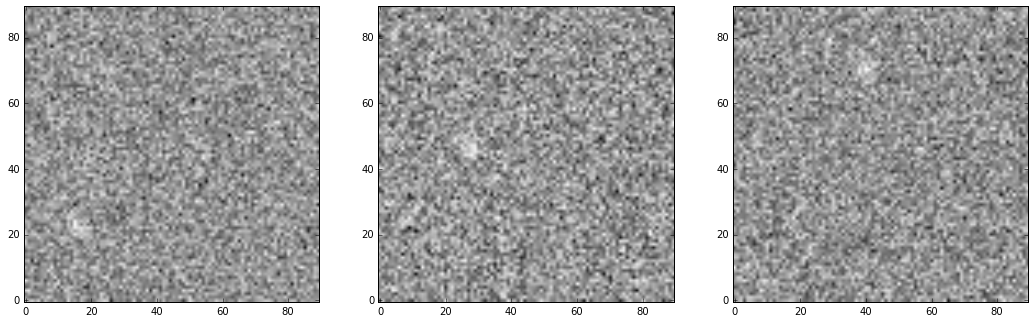

In [107]:
fig = plt.figure(figsize=(18, 6))
for imNum in range(0, 3):
    fig.add_subplot(1, 3, imNum+1)
    plt.imshow(hdulist[0].data[imNum]-(backgroundLevel*np.ones((imageSize))), cmap=mpl.cm.Greys_r, origin='lower')#, norm=mpl.colors.LogNorm())

With images loaded we can convolve each image with a Gaussian and plot the results.

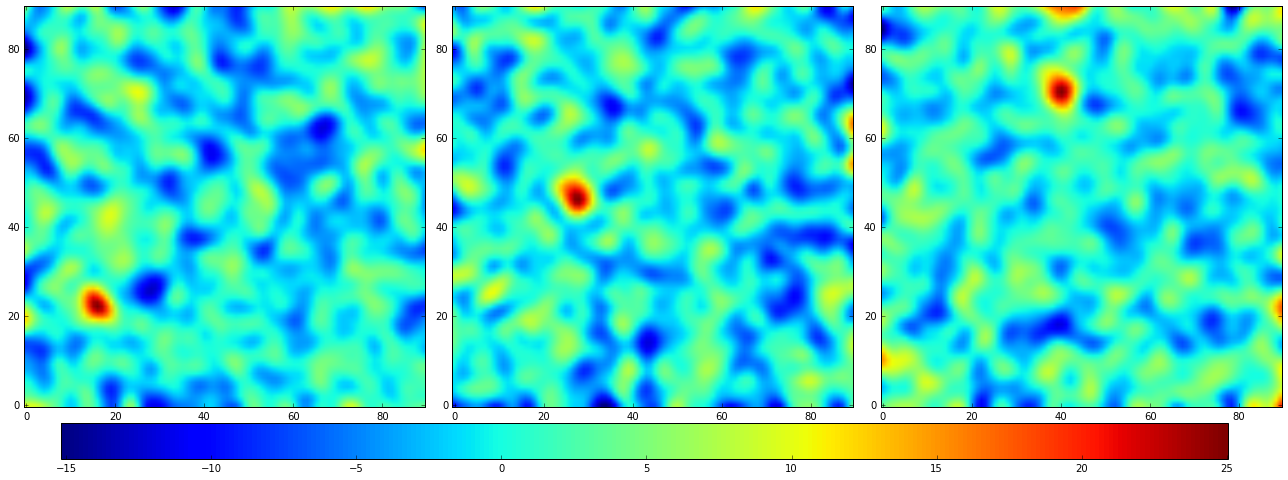

In [108]:
fig, axes = plt.subplots(nrows=1, ncols=len(imageTimes))
fig.set_size_inches(18, 10)
kernel_sigma = [2., 2.]
likelihoodImages = np.zeros(np.shape(hdulist[0].data))
for ax, imNum in zip(axes.flat, np.arange(len(imageTimes))):
    likelihoodImages[imNum] = createImage().convolveGaussian(hdulist[0].data[imNum]-(backgroundLevel*np.ones((imageSize))), kernel_sigma)
    im = ax.imshow(likelihoodImages[imNum], origin='lower')
cbar_ax = fig.add_axes([0.05, 0.15, 0.9, 0.05])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
plt.tight_layout()

We can approximate the flux of the source from each image.

In [95]:
fluxResults = analyzeImage().measureFlux(hdulist[0].data, backgroundLevel, t0Pos, velocity, 
                                         imageTimes, gaussianSigma, verbose = False)

In [96]:
print sourceFlux, np.mean(fluxResults)

1000.0 1145.46317785


Also, we can calculate the likelihood values at each point in the trajectory.

In [97]:
likeSource = analyzeImage().measureLikelihood(likelihoodImages, t0Pos, velocity, imageTimes, 2., verbose=True)
likeSourceProd = np.prod(likeSource)

Trajectory Coordinates: (x,y)
[[ 16.  22.]
 [ 28.  46.]
 [ 40.  70.]]
Likelihood values at coordinates:  [[37.591769270678583], [39.230340779536022], [38.782509064231256]]


Compare to alternate trajectory.

In [98]:
faket0Pos = [60., 80.]
fakevelocity = [-10., -10.]
likeCompare = analyzeImage().measureLikelihood(likelihoodImages, faket0Pos, fakevelocity, imageTimes, 2., verbose=True)
likeCompareProd = np.prod(likeCompare)

Trajectory Coordinates: (x,y)
[[ 50.  70.]
 [ 30.  50.]
 [ 10.  30.]]
Likelihood values at coordinates:  [[23.669962245584969], [20.085930563186263], [15.293969292444279]]


In [99]:
print likeSourceProd
print likeCompareProd
print likeSourceProd/likeCompareProd

57194.0367108
7271.2610382
7.86576584313


In [109]:
faket0Pos = [60., 80.]
fakevelocity = [-10., -10.]
backgroundLevel = 10000.
likelihoodRatioArray = []
snrArray = []
if os.path.exists(str(fileName+'.fits')):
    os.remove(str(fileName+'.fits'))
if os.path.exists(str(fileName+'_var.fits')):
    os.remove(str(fileName+'_var.fits'))
for sourceFlux in range(500, 2501, 50):
    print sourceFlux
    numAttempts = 10
    likelihoodRatio = np.zeros(numAttempts)
    snrVals = np.zeros(len(imageTimes))
    centerPos = createImage().calcCenters(t0Pos, velocity, imageTimes)
    for attempt in range(0,numAttempts):
        createImage().createSingleSet(fileName, t0Pos, velocity, imageTimes, imageSize,
                                      backgroundLevel, sourceFlux, gaussianSigma)
        hdulist = fits.open('test.fits')
        likelihoodImages = np.zeros(np.shape(hdulist[0].data))
        for imNum in np.arange(len(imageTimes)):
            likelihoodImages[imNum] = createImage().convolveGaussian(hdulist[0].data[imNum]-(backgroundLevel*np.ones((imageSize))), 
                                                                     kernel_sigma)
            if attempt == 0:
                snrVals[imNum] = analyzeImage().calcSNR(sourceFlux, centerPos[imNum], gaussianSigma,
                                                       backgroundLevel, imageSize, scaleFactor = 1.5)
        likeResults = analyzeImage().measureLikelihood(likelihoodImages, t0Pos, velocity, imageTimes, 2.)
        likeResultsProd = np.prod(likeResults)
        likeCompare = analyzeImage().measureLikelihood(likelihoodImages, faket0Pos, fakevelocity, imageTimes, 2.)
        likeCompareProd = np.prod(likeCompare)
        likelihoodRatio[attempt] = likeResultsProd/likeCompareProd
        os.remove('test.fits')
        os.remove('test_var.fits')
    likelihoodRatioArray.append(np.mean(likelihoodRatio))
    snrArray.append(np.sqrt(np.sum(snrVals**2)))
likelihoodRatioArray = np.array(likelihoodRatioArray)
snrArray = np.array(snrArray)

500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500


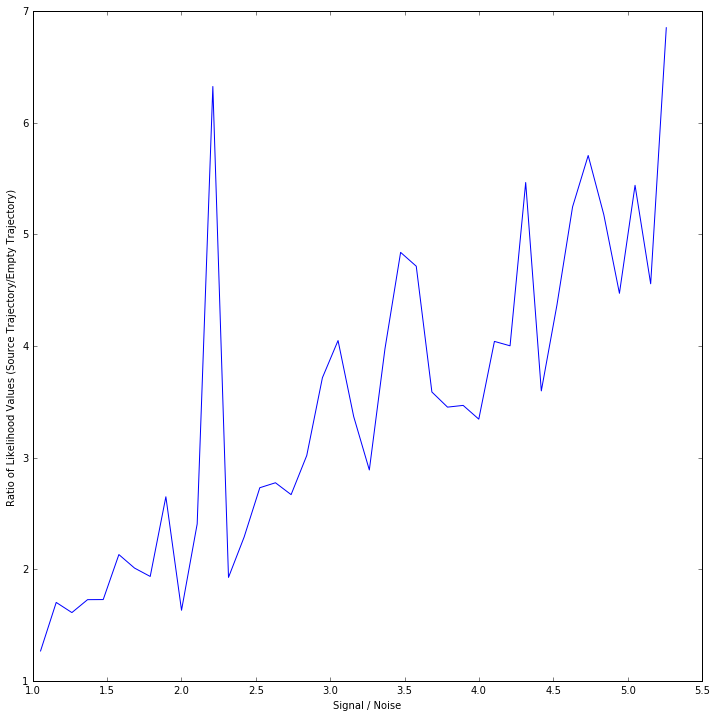

In [110]:
fig = plt.figure(figsize=(12,12))
plt.plot(snrArray, likelihoodRatioArray)
plt.xlabel('Signal / Noise')
plt.ylabel('Ratio of Likelihood Values (Source Trajectory/Empty Trajectory)')

In [15]:
faket0Pos1 = [60., 80.]
fakevelocity1 = [-5., -5.]
likelihoodRatioArrayTime10 = []
sourceFlux = 10.
for numImages in range(3,39):
    print numImages
    numAttempts = 2
    likelihoodRatio = np.zeros(numAttempts)
    for attempt in range(0,numAttempts):
        imageTimes = np.arange(0.1, 6.2, 6./numImages)
        createImage().createSingleSet(fileName, faket0Pos1, fakevelocity1, imageTimes, imageSize,
                                      backgroundLevel, sourceFlux, gaussianSigma)
        hdulist = fits.open('test.fits')
        likelihoodImages = np.zeros(np.shape(hdulist[0].data))
        for imNum in np.arange(len(imageTimes)):
            likelihoodImages[imNum] = createImage().convolveGaussian(hdulist[0].data[imNum]-(backgroundLevel*np.ones((imageSize))), 
                                                                     kernel_sigma)
        fluxResults = analyzeImage().measureFlux(likelihoodImages, t0Pos, velocity, imageTimes, 2.)
        fluxResultsProd = np.prod(fluxResults)
        fluxCompare = analyzeImage().measureFlux(likelihoodImages, faket0Pos, fakevelocity, imageTimes, 2.)
        fluxCompareProd = np.prod(fluxCompare)
        likelihoodRatio[attempt] = fluxResultsProd/fluxCompareProd
        os.remove('test.fits')
    likelihoodRatioArrayTime10.append(np.mean(likelihoodRatio))
likelihoodRatioArrayTime10True = np.array(likelihoodRatioArrayTime10)

3


TypeError: measureFlux() takes at least 7 arguments (6 given)

In [ ]:
fig = plt.figure(figsize=(15,5))
#fig.add_subplot(1,3,1)
#plt.plot(np.arange(3,39), likelihoodRatioArrayTime)
#plt.xlabel('# of images')
#plt.ylabel('Likelihood Ratio')
#plt.title('Source Flux = 4')
fig.add_subplot(1,3,2)
plt.plot(np.arange(3,39), likelihoodRatioArrayTime10, c='g')
plt.xlabel('# of images')
plt.title('Source Flux = 10')
#fig.add_subplot(1,3,3)
#plt.plot(np.arange(3,39), likelihoodRatioArrayTime2, c='r')
#plt.xlabel('# of images')
#plt.title('Source Flux = 40')